In [1]:
import polars as pl
from bill_law_similarity.vector import preprocess
from bill_law_similarity.main import load_df, similarity_metrics

%load_ext autoreload
%autoreload 2

/home/peter/anaconda3/envs/billlaw/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_en = load_df("test", "en")
test_de = load_df("test", "de")

100%|██████████| 944/944 [00:24<00:00, 38.80it/s]


In [3]:
def pipeline(lang, to_csv=True):
    train = load_df("train", lang)
    train = similarity_metrics(train)
    
    val = load_df("val", lang)
    val = similarity_metrics(val)
    
    test = load_df("test", lang)
    test = similarity_metrics(test)

    return train, val, test

In [4]:
train_metrics_de, val_metrics_de, test_metrics_de = pipeline("de")
# uncomment for using pre-computed metrics
# train_metrics_de = pl.read_csv("data/results/train_metrics_de.csv")
# val_metrics_de = pl.read_csv("data/results/val_metrics_de.csv")
# test_metrics_de = pl.read_csv("data/results/test_metrics_de.csv")

100%|██████████| 944/944 [00:55<00:00, 17.09it/s]


In [5]:
train_metrics_en, val_metrics_en, test_metrics_en = pipeline("en")

# uncomment for using pre-computed metrics
# train_metrics_en = pl.read_csv("data/results/train_metrics_en.csv")
# val_metrics_en = pl.read_csv("data/results/val_metrics_en.csv")
# test_metrics_en = pl.read_csv("data/results/test_metrics_en.csv")

100%|██████████| 944/944 [00:21<00:00, 43.70it/s] 


In [8]:
test_de = load_df("test", "de", preprocessing=False).with_columns([
    pl.col("label") / 4
])
test_en = load_df("test", "en", preprocessing=False).with_columns([
    pl.col("label") / 4
])

Get the metrics from the [paper](https://aclanthology.org/2021.emnlp-main.787/)

In [6]:
paper_pred_de = pl.read_csv("data/predictions/test_preds_de.csv")
paper_pred_en = pl.read_csv("data/predictions/test_preds_en.csv")
test_metrics_de = test_metrics_de.with_columns([
    pl.Series(paper_pred_de["paper_preds"]/4).alias("bert_paper"),
])
test_metrics_en = test_metrics_en.with_columns([
    pl.Series(paper_pred_en["paper_preds"] /4).alias("bert_paper"),
])

In [7]:
# spearman correlation
from scipy.stats import spearmanr

def evaluate_spearmanr(test_metrics, labels):
    results = []
    for col in test_metrics.columns:
        corr = spearmanr(test_metrics[col], labels)
        results.append((col, corr.correlation))
    return pl.DataFrame(results, schema=["method", "corr"]).sort(by="corr",descending=False)

In [18]:
eval_en = evaluate_spearmanr(test_metrics_en[:,15:], test_en["label"])

/home/peter/anaconda3/envs/billlaw/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [20]:
eval_en

method,corr
str,f64
"""sw_align""",0.602116
"""bert_max_avg""",0.61897
"""jaro_winkler""",0.80521
"""docu_toads""",0.818077
"""docu_toads_lem…",0.818133
"""bert_aligned""",0.863892
"""bert_avg_pool""",0.891582
"""bert_full""",0.891588
"""tfidf_cos_sim""",0.900144


Text(0.5, 0, 'Spearman Correlation')

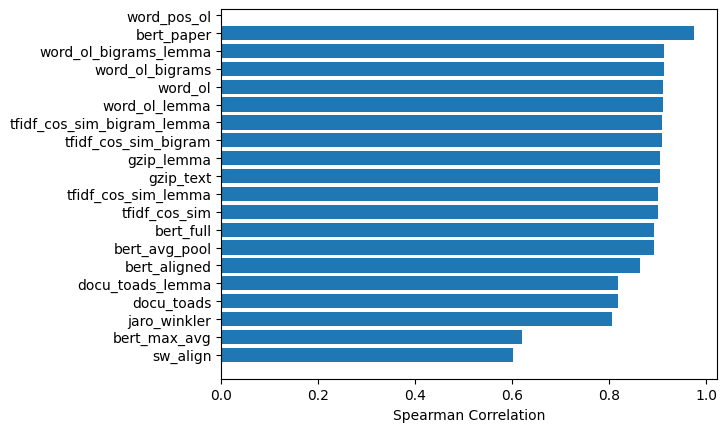

In [19]:
from matplotlib import pyplot as plt
plt.barh(eval_en["method"].to_numpy(), eval_en["corr"].to_numpy())
plt.xlabel("Spearman Correlation")


In [21]:
eval_de = evaluate_spearmanr(test_metrics_de[:,15:], test_de["label"])

/home/peter/anaconda3/envs/billlaw/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [22]:
eval_de

method,corr
str,f64
"""bert_max_avg""",0.4386
"""sw_align""",0.602116
"""jaro_winkler""",0.80521
"""docu_toads""",0.818077
"""docu_toads_lem…",0.821657
"""bert_avg_pool""",0.827813
"""bert_aligned""",0.868761
"""bert_full""",0.891588
"""tfidf_cos_sim""",0.900146


Text(0.5, 0, 'Spearman Correlation')

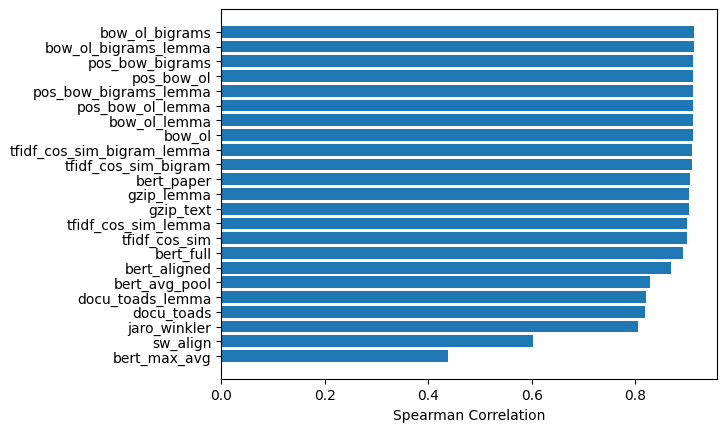

In [66]:
from matplotlib import pyplot as plt
plt.barh(eval_de["method"].to_numpy(), eval_de["corr"].to_numpy())
plt.xlabel("Spearman Correlation")

In [23]:
eval_en.write_csv("data/results/correlations_en_2.csv")
eval_de.write_csv("data/results/correlations_de_2.csv")

# Qualitative Evaluation

DataFrame annotated manually

In [16]:
qeval = test_metrics_en[["pos_bow_bigrams_lemma", "bert_paper"]].with_columns([
    pl.Series(test_en["label"]).alias("label"),
    (pl.col("pos_bow_bigrams_lemma") - pl.col("bert_paper")).abs().alias("delta"),
    # index column
    pl.Series(list(range(0, len(test_metrics_en)))).alias("index"),
    pl.Series(test_en["bill_text"]).alias("bill_text"),
    pl.Series(test_en["law_text"]).alias("law_text"),
]).sort(by="delta", descending=True)
#qeval.write_json("data/results/qeval_en.json", row_oriented=True)